In [139]:
import pandas as pd
import os

def load_close_prices(folder_path, interval='1H'):
    data = {}
    for file in os.listdir(folder_path):
        if file.endswith(f'{interval}.csv'):
            coin = file.replace(f'_{interval}.csv', '')
            df = pd.read_csv(
                os.path.join(folder_path, file),
                index_col='timestamp')
            df.index = pd.to_datetime(df.index, unit='ms')
            data[coin] = df['close']
    return pd.DataFrame(data)

def lagged_corr(series1, series2, max_lag):
    best_corr = 0
    for lag in range(-max_lag, max_lag + 1):
        shifted = series2.shift(lag)
        corr = series1.corr(shifted)
        if abs(corr) > abs(best_corr):
            best_corr = corr
    return best_corr

def compute_correlation_matrix(data, anchors, targets, max_lag):
    matrix = pd.DataFrame(index=anchors, columns=targets)
    for anchor in anchors:
        for target in targets:
            if anchor != target:
                matrix.loc[anchor, target] = lagged_corr(data[anchor], data[target], max_lag)
            else:
                matrix.loc[anchor, target] = 1.0
    return matrix.astype(float)

def best_lag(series1, series2, max_lag):
    best_corr = 0
    best_lag = 0
    for lag in range(-max_lag, max_lag + 1):
        shifted = series2.shift(lag)
        corr = series1.corr(shifted)
        if abs(corr) > abs(best_corr):
            best_corr = corr
            best_lag = lag
    return best_lag

def compute_lag_matrix(data, anchors, targets, max_lag):
    matrix = pd.DataFrame(index=anchors, columns=targets)
    for anchor in anchors:
        for target in targets:
            if anchor != target:
                matrix.loc[anchor, target] = best_lag(data[anchor], data[target], max_lag)
            else:
                matrix.loc[anchor, target] = 1.0
    return matrix.astype(float)

def compute_target_heatmap(corr_matrix):
    return corr_matrix.abs().mean(axis=0).sort_values(ascending=False)

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(corr_matrix, title="Lagged Correlation Heatmap"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(title)
    plt.show()

def plot_target_hotness(heat_series):
    plt.figure(figsize=(10, 4))
    sns.barplot(x=heat_series.index, y=heat_series.values, palette='flare')
    plt.title("Target Coin Hotness (Avg. Lagged Correlation with Anchors)")
    plt.ylabel("Average |Correlation|")
    plt.xticks(rotation=90)
    plt.show()

import matplotlib.pyplot as plt
import pandas as pd

def plot_anchors_and_target(data, anchors, target, lag=0, interval_hours=1):
    # 1   keep only the columns we need
    coins = anchors + target
    subset = data[coins].dropna()

    # 2   z-score normalisation
    normalised = (subset - subset.mean()) / subset.std()

    # 3   make the lagged target series
    lagged_target = normalised[target].shift(lag)

    # 4   shift timestamps the opposite way so the lag is visible
    lagged_target.index = lagged_target.index + pd.Timedelta(hours=lag*interval_hours)

    # 5   drop NaNs created by the value shift
    lagged_target = lagged_target.dropna()

    print(lagged_target.index - pd.Timedelta(hours=lag*interval_hours))
    print(lagged_target)
    # ──────────────────────── plotting ────────────────────────
    plt.figure(figsize=(14, 6))

    # subplot 1  –  no lag
    plt.subplot(1, 2, 1)
    for coin in anchors:
        plt.plot(normalised.index, normalised[coin], label=coin)
    plt.plot(normalised.index, normalised[target],
             linestyle='--', label=f"{target} (no lag)")
    plt.title("Anchors vs Target (Normalised, No Lag)")
    plt.xlabel("Time")
    plt.ylabel("Z-score")
    plt.legend()

    # subplot 2  –  with lag
    plt.subplot(1, 2, 2)
    for coin in anchors:
        plt.plot(normalised.index, normalised[coin], label=coin)
    plt.plot(lagged_target.index, lagged_target,
             linestyle='--', label=f"{target} (lag = {lag})")
    plt.title(f"Anchors vs Target (Normalised, Lag = {lag})")
    plt.xlabel("Time")
    plt.ylabel("Z-score")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [141]:
data_with_na = load_close_prices('../../Data', interval='1H')
data = data_with_na.dropna(axis=1)
anchors = ['BTC', 'ETH', 'SOL']
targets = [coin for coin in data.columns if coin not in anchors]

missing_timeframe_coins = set(data_with_na) - set(data);
print(f"{len(missing_timeframe_coins)} coins have missing timeframes: ")
print(missing_timeframe_coins)

max_lag = 6;

43 coins have missing timeframes: 
{'ONDO', 'BERA', 'TROY', 'SHELL', 'BURGER', 'SYRUP', 'TUT', 'ANIME', 'BNX', 'AIXBT', 'TST', 'S', 'MUBARAK', 'SIGN', 'GUN', 'BMT', 'RED', 'BIO', 'LAYER', 'CGPT', 'INIT', 'KAITO', 'NIL', 'TRUMP', 'HYPER', 'ALPACA', 'COOKIE', 'FTM', 'GPS', 'DAR', 'SXT', 'KERNEL', 'PARTI', 'BABY', '1000CHEEMS', 'VIRTUAL', 'FORM', 'SOLV', 'WCT', 'STO', 'KMNO', 'LIT', 'BROCCOLI714'}


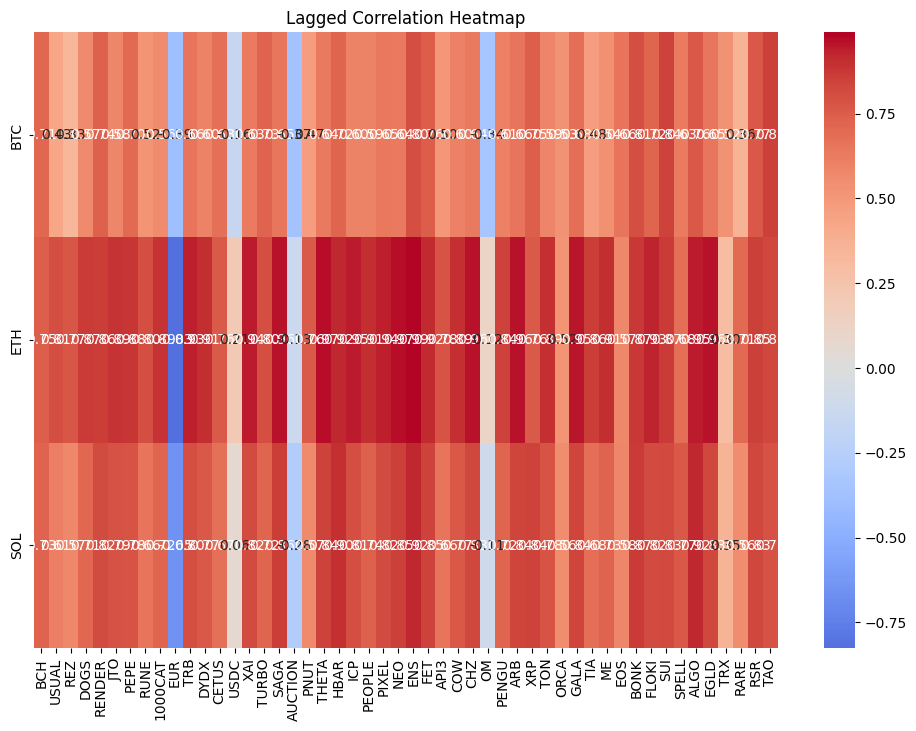

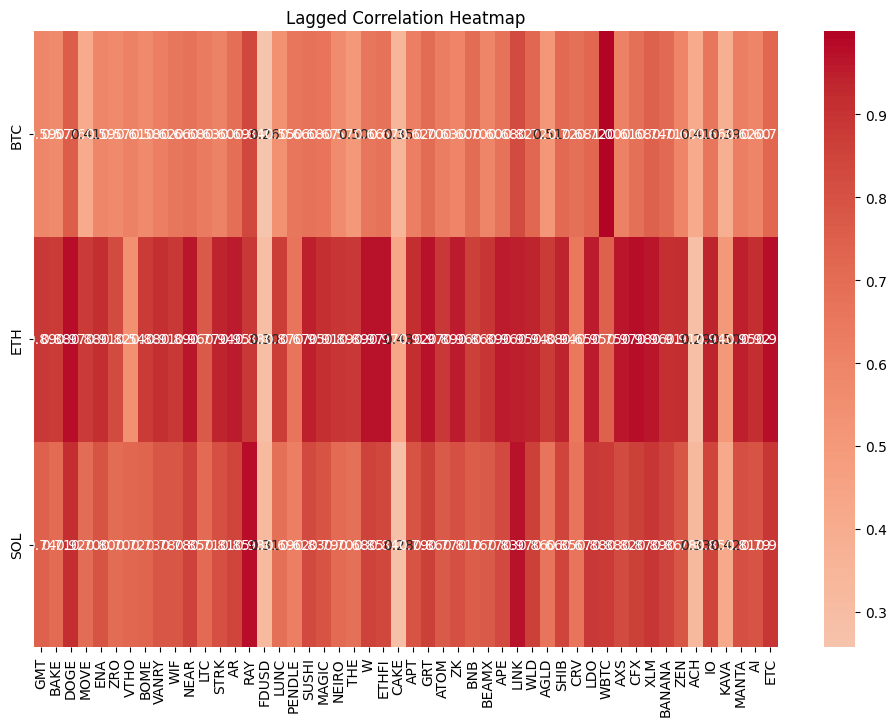

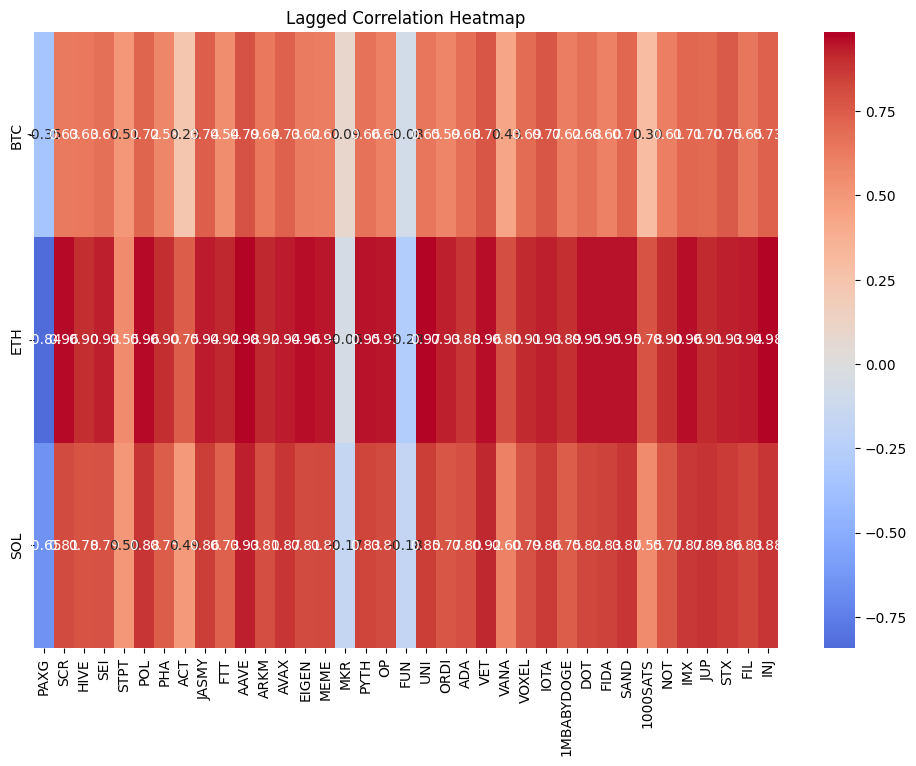

In [142]:
corr_matrix = compute_correlation_matrix(data, anchors, targets[: 50], max_lag)
plot_heatmap(corr_matrix)
corr_matrix = compute_correlation_matrix(data, anchors, targets[50: 100], max_lag)
plot_heatmap(corr_matrix)
corr_matrix = compute_correlation_matrix(data, anchors, targets[100:], max_lag)
plot_heatmap(corr_matrix)

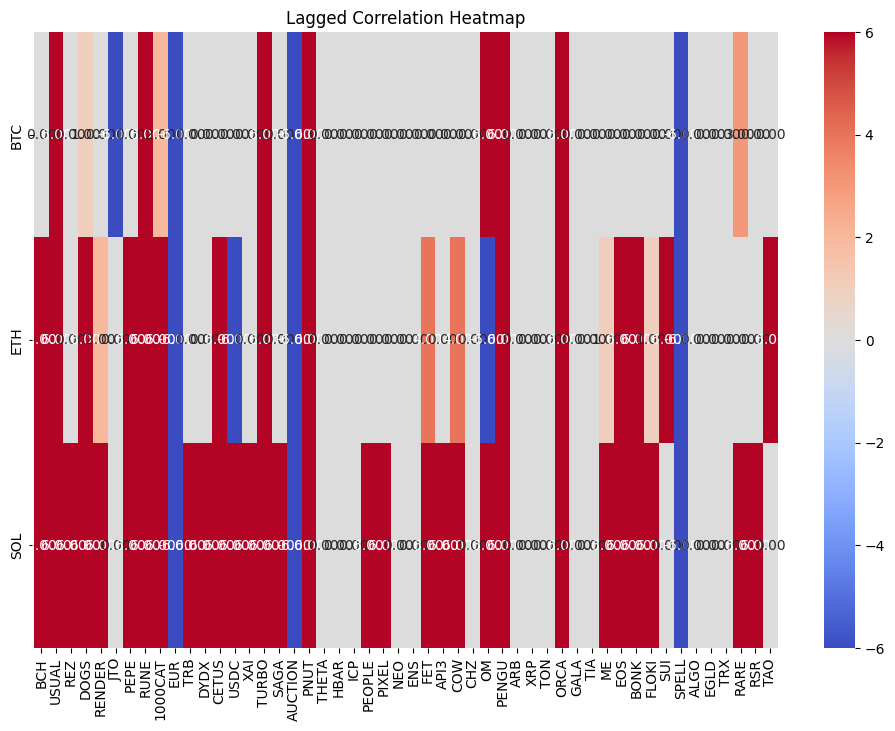

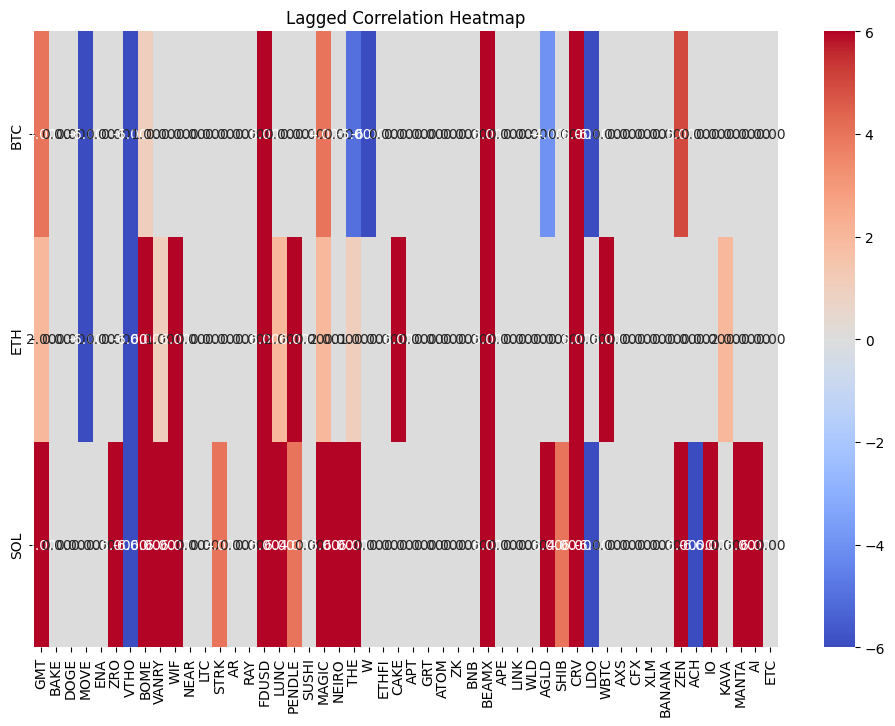

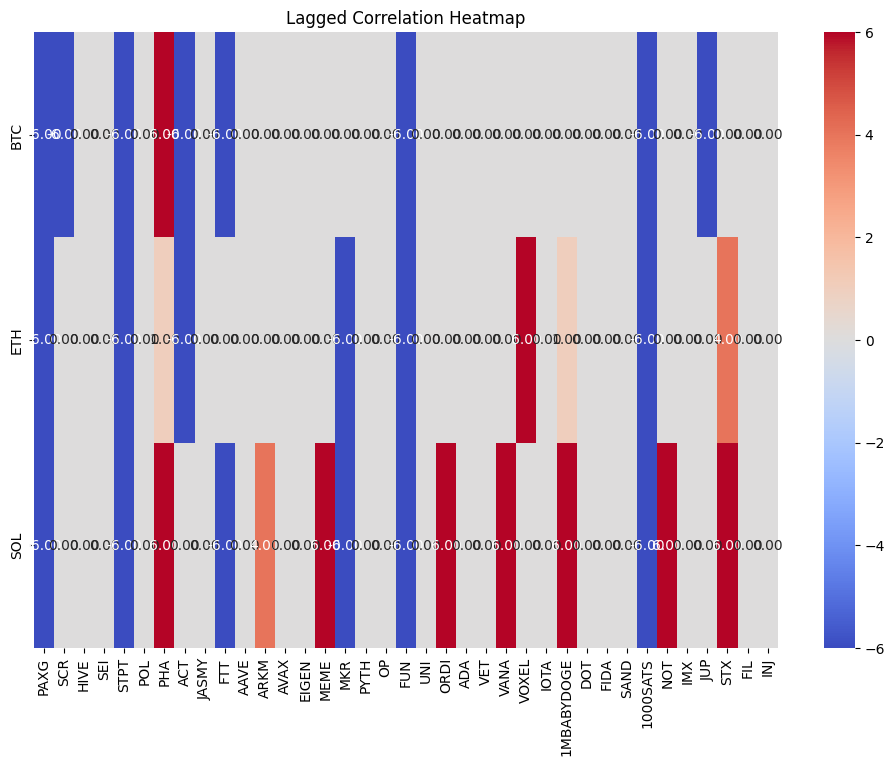

In [143]:
lag_matrix = compute_lag_matrix(data, anchors, targets[: 50], max_lag)
plot_heatmap(lag_matrix)
lag_matrix = compute_lag_matrix(data, anchors, targets[50: 100], max_lag)
plot_heatmap(lag_matrix)
lag_matrix = compute_lag_matrix(data, anchors, targets[100:], max_lag)
plot_heatmap(lag_matrix)

/var/folders/x_/nvtvp_zd75752nhjskbk1p1r0000gn/T/ipykernel_19690/3833604732.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heat_series.index, y=heat_series.values, palette='flare')


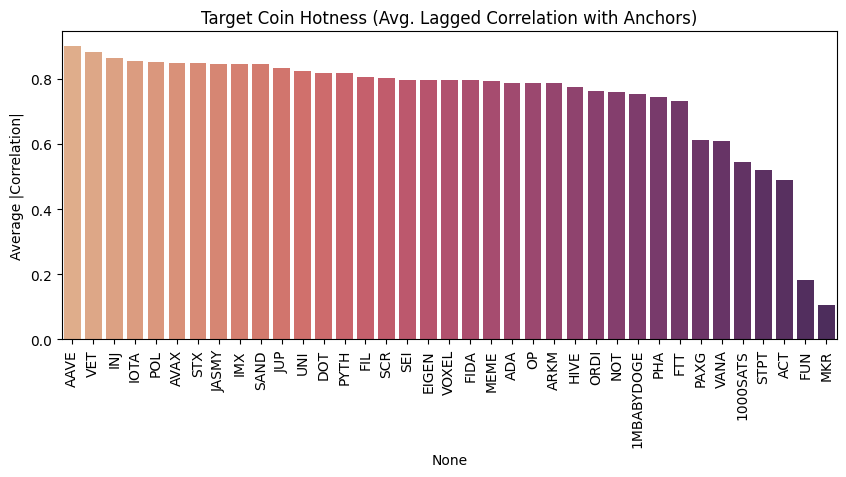

In [144]:
heat_series = compute_target_heatmap(corr_matrix)
plot_target_hotness(heat_series)

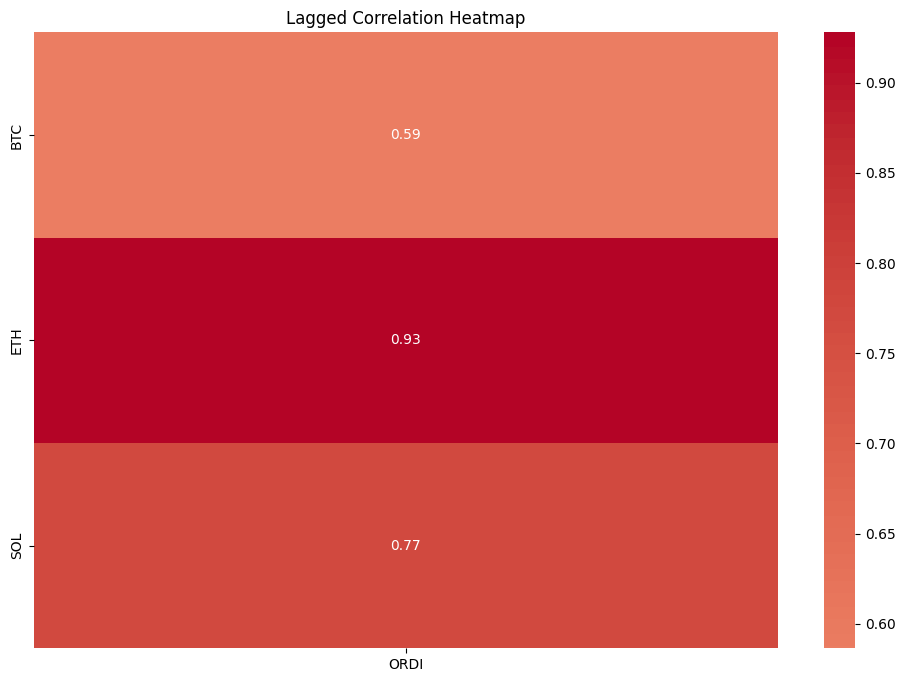

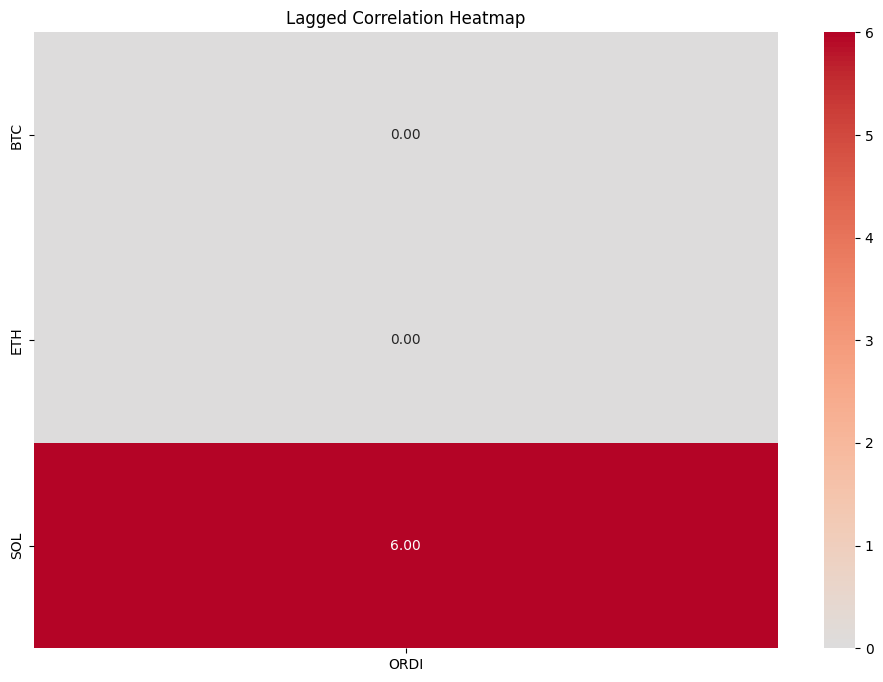

In [145]:
target_token = ["ORDI"]
corr_matrix = compute_correlation_matrix(data, anchors, target_token, max_lag)
plot_heatmap(corr_matrix)
lag_matrix = compute_lag_matrix(data, anchors, target_token, max_lag)
plot_heatmap(lag_matrix)

DatetimeIndex(['2025-01-01 07:00:00', '2025-01-01 08:00:00',
               '2025-01-01 09:00:00', '2025-01-01 10:00:00',
               '2025-01-01 11:00:00', '2025-01-01 12:00:00',
               '2025-01-01 13:00:00', '2025-01-01 14:00:00',
               '2025-01-01 15:00:00', '2025-01-01 16:00:00',
               ...
               '2025-05-14 07:00:00', '2025-05-14 08:00:00',
               '2025-05-14 09:00:00', '2025-05-14 10:00:00',
               '2025-05-14 11:00:00', '2025-05-14 12:00:00',
               '2025-05-14 13:00:00', '2025-05-14 14:00:00',
               '2025-05-14 15:00:00', '2025-05-14 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=3202, freq='h')
                         ORDI
timestamp                    
2025-01-01 13:00:00  2.209102
2025-01-01 14:00:00  2.222749
2025-01-01 15:00:00  2.201520
2025-01-01 16:00:00  2.174225
2025-01-01 17:00:00  2.186356
...                       ...
2025-05-14 18:00:00 -0.009342
2025-05-14 19:00:00 -

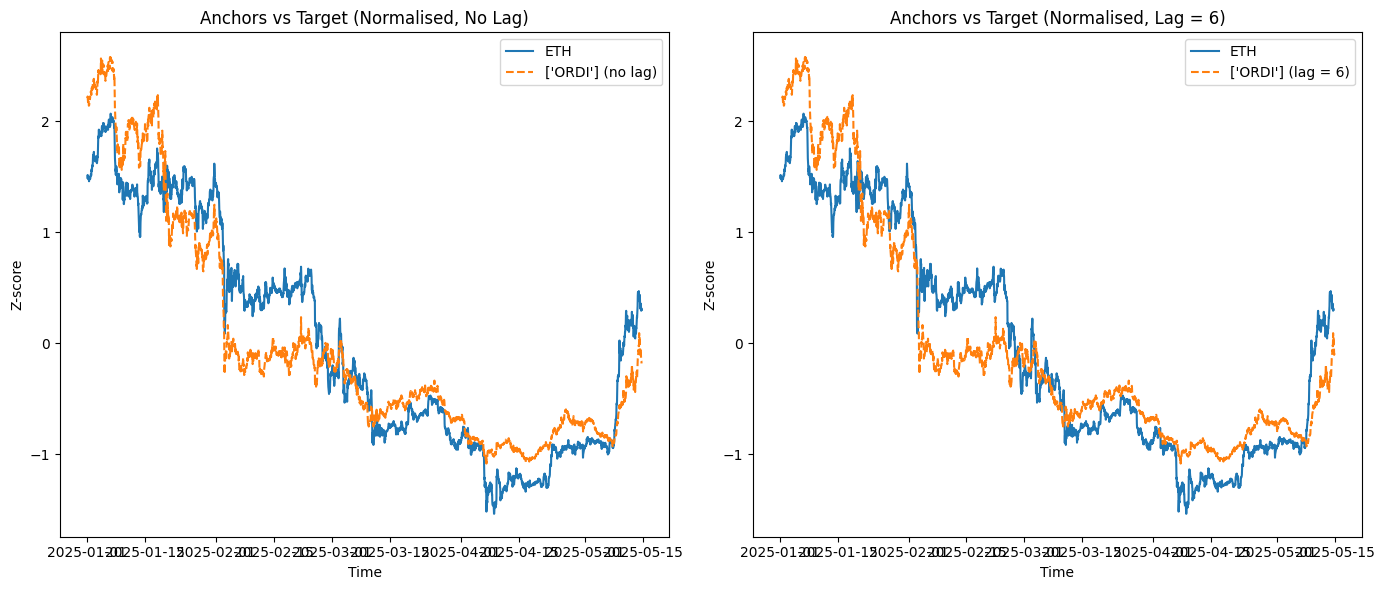

In [146]:
anchor = ["ETH"]
plot_anchors_and_target(data, anchor, target_token, lag=6)